# Introduction
This project will use the confusion EEG dataset hosted on Kaggle at https://www.kaggle.com/wanghaohan/eeg-brain-wave-for-confusion.  This dataset consists of EEG data taken from students watching MOOC courses of varying difficulty.  The purpose is to identify signals from the EEG that indicate whether or not the student is confused by the subject matter.  In theory confusing subject matter should require additional concentration, or at least a different type of focus from the student, which may be visible in the EEG data.

In [290]:
from pandas import read_csv, concat, DataFrame
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from sklearn.cross_validation import train_test_split, cross_val_score, LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
raw_data = read_csv("data/EEG data.csv")

In [3]:
raw_data.head()

,subject ID,Video ID,Attention,Meditation,Raw,Delta,Theta,Alpha 1,Alpha 2,Beta 1,Beta 2,Gamma1,Gamma2,predefined label,Self-defined label
0,0,0,56,43,278,301963,90612,33735,23991,27946,45097,33228,8293,0,0
1,0,0,40,35,-50,73787,28083,1439,2240,2746,3687,5293,2740,0,0
2,0,0,47,48,101,758353,383745,201999,62107,36293,130536,57243,25354,0,0
3,0,0,47,57,-5,2012240,129350,61236,17084,11488,62462,49960,33932,0,0
4,0,0,44,53,-8,1005145,354328,37102,88881,45307,99603,44790,29749,0,0


For these purposes I will group the data by session (one subject and one video) and use the values of the brainwaves in each of the reported ranges.  I will not be using the raw data as it doesn't look like there is enough resolution in the data to see individual brain waves on their own.  I will also not use the propriatary measurements.  They are likely computed as a function of the rest of the data, and therefore not likely useful on their own.  They are also less useful without information on how they are computed.
For the label, I will use the self defined label, since I feel that is more trustworthy.

In [369]:
feature_data = raw_data[['subject ID', 'Video ID', "Delta", "Theta", "Alpha 1", "Alpha 2", "Beta 1", "Beta 2", "Gamma1", "Gamma2", 'Self-defined label']]
sessions = feature_data.groupby(['subject ID', 'Video ID'])

Lets first try a simple logistic regression against the average values for each of the given brain waves.

In [370]:
aggregated = sessions.aggregate(np.mean)
cols = aggregated.columns[:-1]
averages = aggregated[cols]
averages.columns = ["Average " + col for col in cols]
target = aggregated[aggregated.columns[-1]]
average_data = (averages, target)

def test_model(model, data):
    """
    Run the given model against our data
    """
    features, target = data
    scores = cross_val_score(model, features, target, cv=40, scoring='accuracy')
    return np.mean(scores)


In [371]:
print "Logistic Regression"
print test_model(LogisticRegression(random_state=42) , average_data)

Logistic Regression
0.5875


This gives us a 58.75% accuarcy.  This is not too bad as a first try for this data set, as the researchers report a 65% accuracy as being good.  Nethertheless, lets try a few more models

In [372]:
print "Decision Tree"
print test_model(DecisionTreeClassifier(random_state=42), average_data)
print "Gradient Boosting"
print test_model(GradientBoostingClassifier(random_state=42), average_data)
print "AdaBoost"
print test_model(AdaBoostClassifier(random_state=42), average_data)
print "Nearest Neighbor"
print test_model(KNeighborsClassifier(n_neighbors=1), average_data)
print "3 Nearest Neighbors"
print test_model(KNeighborsClassifier(n_neighbors=3), average_data)

Decision Tree
0.691666666667
Gradient Boosting
0.747916666667
AdaBoost
0.764583333333
Nearest Neighbor
0.645833333333
3 Nearest Neighbors
0.6875


The ensemble methods seem to be doing the best, with the AdaBoost algorithm getting an accuracy of over 75%.

We can try expanding our features to include other measurements, such as the standard deviations of the levels for each group of brainwaves.  This could help if changes in the brain waves are indictative of confusion, in addition to average values.

In [373]:
std_deviations = sessions.aggregate(np.std)[cols]
std_deviations.columns = [col + " std" for col in cols]
all_features = concat([averages, std_deviations], axis=1)
all_data = (all_features, target)

In [374]:
print "Logistic Regression"
print test_model(LogisticRegression(random_state=42) , all_data)
print "Decision Tree"
print test_model(DecisionTreeClassifier(random_state=42), all_data)
print "Gradient Boosting"
print test_model(GradientBoostingClassifier(random_state=42), all_data)
print "AdaBoost"
print test_model(AdaBoostClassifier(random_state=42), all_data)
print "Nearest Neighbor"
print test_model(KNeighborsClassifier(n_neighbors=1), all_data)
print "3 Nearest Neighbors"
print test_model(KNeighborsClassifier(n_neighbors=3), all_data)

Logistic Regression
0.59375
Decision Tree
0.777083333333
Gradient Boosting
0.725
AdaBoost
0.7125
Nearest Neighbor
0.65
3 Nearest Neighbors
0.704166666667


With the additional features, some models (such as decision trees and 3 nearest neighbors) improved, but both the ensemble algorithms did slightly more poorly.  However, the best performing algorithms remain those using decision trees, with the plain decision tree classifier now performing the best.  Luckily this is a classifier that is relatlively easy to interpret, so we can train one on all the data and see what it is keying off of.

In [375]:
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(all_features, target)
DataFrame(classifier.feature_importances_, index=all_features.columns).sort_values(0, ascending=False)

,0
Average Theta,0.270108
Gamma2 std,0.167580
Average Beta 2,0.137392
Average Alpha 1,0.095932
Alpha 2 std,0.090207
Average Gamma2,0.065985
Average Delta,0.046079
Average Alpha 2,0.043351
Gamma1 std,0.036681
Alpha 1 std,0.026677


Interestingly, the most important feature is the average theta value.  This is significant as the researchers mention past research suggests theta values correlate with confusion levels.  The deviation of gamma 2 brainwaves and the average beta 2 brainwaves are also relatively significant.

Because the data is only collected among 10 students and for 10 different videos (they are not independent), it is also important to see how well it generalizes among different students and different videos.  We can use scikit learn's LabelKFold to perform that.

Across different students:
	mean: %f, standard deviation: %f (0.69999999999999996, 0.18973665961010278)
Across different videos:
	mean: %f, standard deviation: %f (0.71999999999999997, 0.14696938456699071)


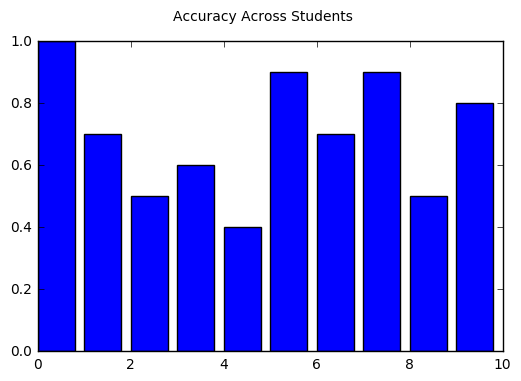

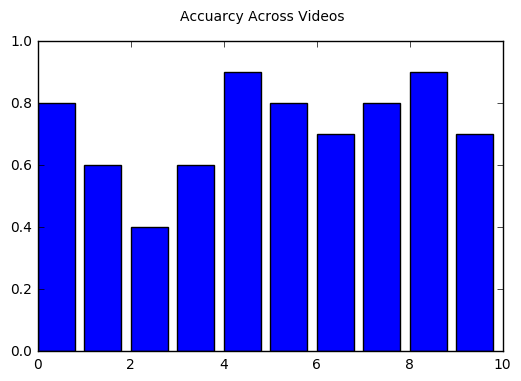

In [376]:
student_labels = map(lambda x: x[0], all_features.index.tolist())
video_labels = map(lambda x: x[1], all_features.index.tolist())
student_k_fold = LabelKFold(student_labels, 10)
video_k_fold = LabelKFold(video_labels, 10)
def test_fold(fold, model, x, y):
    train_indexes, test_indexes = fold
    x_train = x.as_matrix()[train_indexes]
    x_test = x.as_matrix()[test_indexes]
    y_train = y.as_matrix()[train_indexes]
    y_test = y.as_matrix()[test_indexes]
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    return accuracy_score(y_test, predicted)

student_results = [test_fold(fold, classifier, all_features, target) for fold in student_k_fold]
student_results.reverse()
print "Across different students:"
print "\tmean: %f, standard deviation: %f", (np.mean(student_results), np.std(student_results))
student_plot = pyplot.figure()
student_plot.suptitle("Accuracy Across Students")
pyplot.bar(range(10), student_results)
pyplot.ylim((0,1.0))
video_results = [test_fold(fold, classifier, all_features, target) for fold in video_k_fold]
video_results.reverse()
print "Across different videos:"
print "\tmean: %f, standard deviation: %f", (np.mean(video_results), np.std(video_results))
video_plot = pyplot.figure()
video_plot.suptitle("Accuarcy Across Videos")
pyplot.bar(range(10), video_results)
pyplot.ylim(0,1.0)
pyplot.show()

For the most part the models did generalize across both students and videos, getting average accuracies of 70% on both.  However, there were three students and one video where the model was correct half the time or less.

The lack of consistency among students isn't that worrying.  Putting aside potential differences in individual brains, the measurement of confusion is subjective, so its perfectly possible different students were grading their confusion levels on different scales.  It would be interesting to perform this experiment with a more objective measurement of confusion levels, for instance the student's ability to pass a quiz on the subject matter.

The fact that it was able to correctly determine the confusion levels 70% of the time or better on 7 out of 10 videos, and 80% or better on half the videos, is also encouraging.  There may be some v for which the models would be unable to 